In [1]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, average_precision_score, auc, brier_score_loss, matthews_corrcoef, roc_auc_score, roc_curve, precision_recall_curve
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
import pickle

### Variazione delta a 9 mesi

In [18]:
sentinels = ['None', 'n.d.', ' ', '']
df = pd.read_csv('assets/yid_out_9m.tsv', sep='\t', na_values=sentinels)

In [19]:
df.valoreIntero.fillna(df.valoreIntero.mean(), inplace=True)
df.mediaVoto.fillna(df.mediaVoto.mean(), inplace=True)
df.votoDiploma.fillna(round(df.votoDiploma.mean()), inplace=True)

df = df.drop(['luogoDiNascita', 'nazioneNascita'], axis=1)
df = df.astype({'valoreIntero': np.int64, 'votoDiploma': np.int32})
# print(pd.isnull(df).sum() > 0)
print(df.shape)

(70018, 24)


In [20]:
y = df.Dropout
X = df.drop(['Dropout', 'lastLogin', 'annoAccaCors', 'ultIscr', 'creditiTotali', 'ultPren', 'ultSup'], axis = 1)
# print(X.head())

val = {True: 1, False: 0}
X["sesso"] = X["sesso"].map(val)
X = X.astype({'sesso': np.int32})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
mat = X_test.ID_Stud
print("Training Set shape: {}".format(X_train.shape))
print("Test Set shape: {}".format(X_test.shape))

Training Set shape: (56014, 17)
Test Set shape: (14004, 17)


In [21]:
ohe_elements =  ['cittadinanza', 'facolta', 'tipoIscrizione']
with open('assets/encoder.pickle', 'rb') as f:
    encoder = pickle.load(f)
feature_arr = encoder.transform(X_train[ohe_elements]).toarray()
feature_labels = encoder.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
X_train = X_train.reset_index(drop=True)
X_train = X_train.join(encoded_df)
X_train = X_train.drop(ohe_elements, axis=1)
X_train.head()

,ID_Stud,annoCorso,eta,codCorso,flagIdentificato,primaIscr,sesso,tipoCorso,tipoStudente,valoreIntero,...,facolta_LETTERE E FILOSOFIA,facolta_MEDICINA E ODONTOIATRIA,facolta_MEDICINA E PSICOLOGIA,"facolta_SCIENZE MATEMATICHE, FISICHE E NATURALI","facolta_SCIENZE POLITICHE, SOCIOLOGIA, COMUNICAZIONE",facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE,tipoIscrizione_FUORI CORSO,tipoIscrizione_IMMATRICOLAZIONE,tipoIscrizione_IN CORSO,tipoIscrizione_RIPETENTE
0,27009,1,23,30046,1,4,1,27,2,39056,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,52886,2,26,16004,1,6,1,27,2,28534,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,100223,1,23,30043,1,4,0,27,2,23401,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,71420,1,24,15936,0,4,1,27,2,70737,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,30499,3,24,29969,1,4,0,27,2,20816,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
feature_arr = encoder.transform(X_test[ohe_elements]).toarray()
feature_labels = encoder.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
X_test = X_test.reset_index(drop=True)
X_test = X_test.join(encoded_df)
X_test = X_test.drop(ohe_elements, axis=1)

X_test.head()

,ID_Stud,annoCorso,eta,codCorso,flagIdentificato,primaIscr,sesso,tipoCorso,tipoStudente,valoreIntero,...,facolta_LETTERE E FILOSOFIA,facolta_MEDICINA E ODONTOIATRIA,facolta_MEDICINA E PSICOLOGIA,"facolta_SCIENZE MATEMATICHE, FISICHE E NATURALI","facolta_SCIENZE POLITICHE, SOCIOLOGIA, COMUNICAZIONE",facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE,tipoIscrizione_FUORI CORSO,tipoIscrizione_IMMATRICOLAZIONE,tipoIscrizione_IN CORSO,tipoIscrizione_RIPETENTE
0,96999,3,23,29864,1,3,1,27,2,60907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,47093,2,26,29391,1,4,0,28,2,32313,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,29483,1,25,30055,1,3,0,28,2,30814,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,53578,1,27,26694,1,4,0,23,2,33302,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,6869,1,24,16074,0,5,1,27,2,32313,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [11]:
if "facolta_PSICOLOGIA 1" in X_train.columns:
    X_train = X_train.drop(['facolta_PSICOLOGIA 1', 'ID_Stud'], axis=1)
    X_test = X_test.drop(['facolta_PSICOLOGIA 1', 'ID_Stud'], axis=1)

In [23]:
model = GradientBoostingClassifier(n_estimators=500, min_samples_leaf=16, max_depth=8, loss='exponential', learning_rate=0.01)
model = model.fit(X_train, y_train)

Confusion matrix:
 [[11016   144]
 [  603  2241]]
Balanced Accuracy Score:  0.8875357288689261
Score:  0.9466580976863753
Brier score:  0.038084474411202204
Matthews corrcoef:  0.8294879281102643
Classification report:
               precision    recall  f1-score   support

       False       0.95      0.99      0.97     11160
        True       0.94      0.79      0.86      2844

    accuracy                           0.95     14004
   macro avg       0.94      0.89      0.91     14004
weighted avg       0.95      0.95      0.94     14004



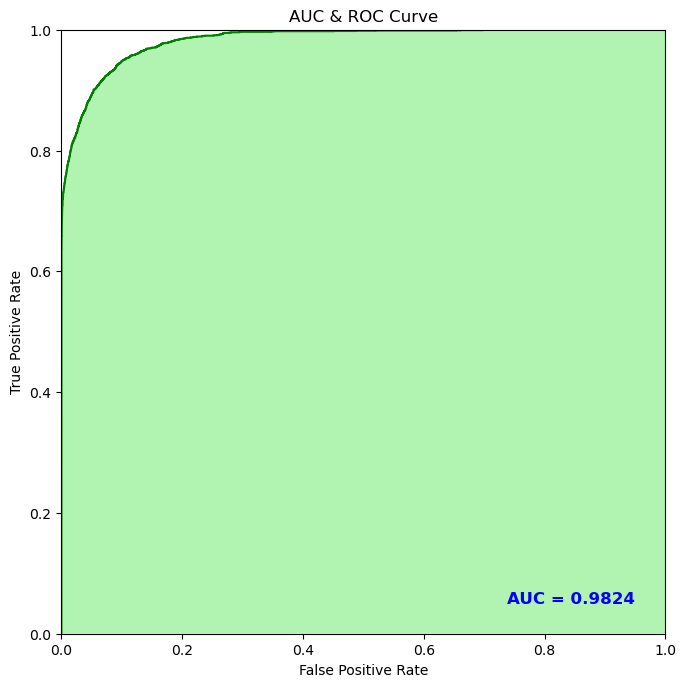

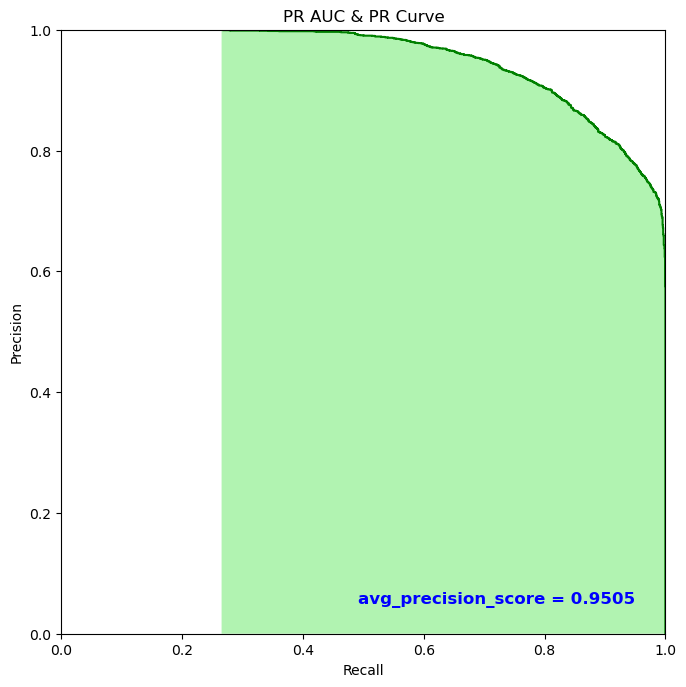

In [24]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

bas = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy Score: ", bas)

s = model.score(X_test, y_test)
print("Score: ", s)

bscore = brier_score_loss(y_test, y_prob)
print("Brier score: ", bscore)

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews corrcoef: ", mcc)

print("Classification report:\n", classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_prob)

prauc = average_precision_score(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, y_prob)

if len(true_positive_rate) < len(recall):
    tpr = np.append(true_positive_rate, (len(recall)-len(true_positive_rate)) * [None])
    fpr = np.append(false_positive_rate, (len(recall)-len(false_positive_rate)) * [None])
    tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : tpr, 'FPR': fpr,
    'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'delta': '250'})
    tmp = tmp.astype({'TPR': np.float64, 'FPR': np.float64})
else:
    tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : true_positive_rate, 'FPR': false_positive_rate,
    'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'delta': '250'})
# tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : true_positive_rate, 'FPR': false_positive_rate,
#     'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'method': 'GBDT'})
tmp.to_csv('assets/auc_res_250.tsv', index = False, sep='\t', mode = 'a', header = None, float_format='%.18f')

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("PR AUC & PR Curve")
plt.plot(precision, recall, 'g')
plt.fill_between(precision, recall, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'avg_precision_score = %0.4f' % prauc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [25]:
print(df[df['Dropout'] == True]['Dropout'].count())

14222


### Delta 4 mesi

In [26]:
sentinels = ['None', 'n.d.', ' ', '']
df = pd.read_csv('assets/yid_out_4m.tsv', sep='\t', na_values=sentinels)

In [27]:
df.valoreIntero.fillna(df.valoreIntero.mean(), inplace=True)
df.mediaVoto.fillna(df.mediaVoto.mean(), inplace=True)
df.votoDiploma.fillna(round(df.votoDiploma.mean()), inplace=True)

df = df.drop(['luogoDiNascita', 'nazioneNascita'], axis=1)
df = df.astype({'valoreIntero': np.int64, 'votoDiploma': np.int32})
# print(pd.isnull(df).sum() > 0)
print(df.shape)

(70018, 24)


In [28]:
y = df.Dropout
X = df.drop(['ID_Stud', 'Dropout', 'lastLogin', 'annoAccaCors', 'ultIscr'], axis = 1)
# print(X.head())

val = {True: 1, False: 0}
X["sesso"] = X["sesso"].map(val)
X = X.astype({'sesso': np.int32})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print("Training Set shape: {}".format(X_train.shape))
print("Test Set shape: {}".format(X_test.shape))

Training Set shape: (56014, 19)
Test Set shape: (14004, 19)


In [29]:
ohe_elements =  ['cittadinanza', 'facolta', 'tipoIscrizione']
with open('assets/encoder.pickle', 'rb') as f:
    encoder = pickle.load(f)
feature_arr = encoder.transform(X_train[ohe_elements]).toarray()
feature_labels = encoder.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
X_train = X_train.reset_index(drop=True)
X_train = X_train.join(encoded_df)
X_train = X_train.drop(ohe_elements, axis=1)
X_train.head()

,annoCorso,eta,codCorso,creditiTotali,flagIdentificato,primaIscr,sesso,tipoCorso,tipoStudente,valoreIntero,...,facolta_LETTERE E FILOSOFIA,facolta_MEDICINA E ODONTOIATRIA,facolta_MEDICINA E PSICOLOGIA,"facolta_SCIENZE MATEMATICHE, FISICHE E NATURALI","facolta_SCIENZE POLITICHE, SOCIOLOGIA, COMUNICAZIONE",facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE,tipoIscrizione_FUORI CORSO,tipoIscrizione_IMMATRICOLAZIONE,tipoIscrizione_IN CORSO,tipoIscrizione_RIPETENTE
0,1,23,30046,180,1,4,1,27,2,39056,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,26,16004,180,1,6,1,27,2,28534,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,23,30043,180,1,4,0,27,2,23401,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,24,15936,180,0,4,1,27,2,70737,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3,24,29969,180,1,4,0,27,2,20816,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
feature_arr = encoder.transform(X_test[ohe_elements]).toarray()
feature_labels = encoder.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
X_test = X_test.reset_index(drop=True)
X_test = X_test.join(encoded_df)
X_test = X_test.drop(ohe_elements, axis=1)

X_test.head()

,annoCorso,eta,codCorso,creditiTotali,flagIdentificato,primaIscr,sesso,tipoCorso,tipoStudente,valoreIntero,...,facolta_LETTERE E FILOSOFIA,facolta_MEDICINA E ODONTOIATRIA,facolta_MEDICINA E PSICOLOGIA,"facolta_SCIENZE MATEMATICHE, FISICHE E NATURALI","facolta_SCIENZE POLITICHE, SOCIOLOGIA, COMUNICAZIONE",facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE,tipoIscrizione_FUORI CORSO,tipoIscrizione_IMMATRICOLAZIONE,tipoIscrizione_IN CORSO,tipoIscrizione_RIPETENTE
0,3,23,29864,180,1,3,1,27,2,60907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,26,29391,120,1,4,0,28,2,32313,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,25,30055,120,1,3,0,28,2,30814,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,27,26694,300,1,4,0,23,2,33302,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,24,16074,180,0,5,1,27,2,32313,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [39]:
if "facolta_PSICOLOGIA 1" in X_train.columns:
    X_train = X_train.drop(['facolta_PSICOLOGIA 1'], axis=1)
    X_test = X_test.drop(['facolta_PSICOLOGIA 1'], axis=1)

In [31]:
model = GradientBoostingClassifier(n_estimators=500, min_samples_leaf=16, max_depth=8, loss='exponential', learning_rate=0.01)
model = model.fit(X_train, y_train)

Confusion matrix:
 [[10987   173]
 [  477  2367]]
Balanced Accuracy Score:  0.9083883444489814
Score:  0.9535846900885462
Brier score:  0.0325616296134764
Matthews corrcoef:  0.8527373403945613
Classification report:
               precision    recall  f1-score   support

       False       0.96      0.98      0.97     11160
        True       0.93      0.83      0.88      2844

    accuracy                           0.95     14004
   macro avg       0.95      0.91      0.93     14004
weighted avg       0.95      0.95      0.95     14004



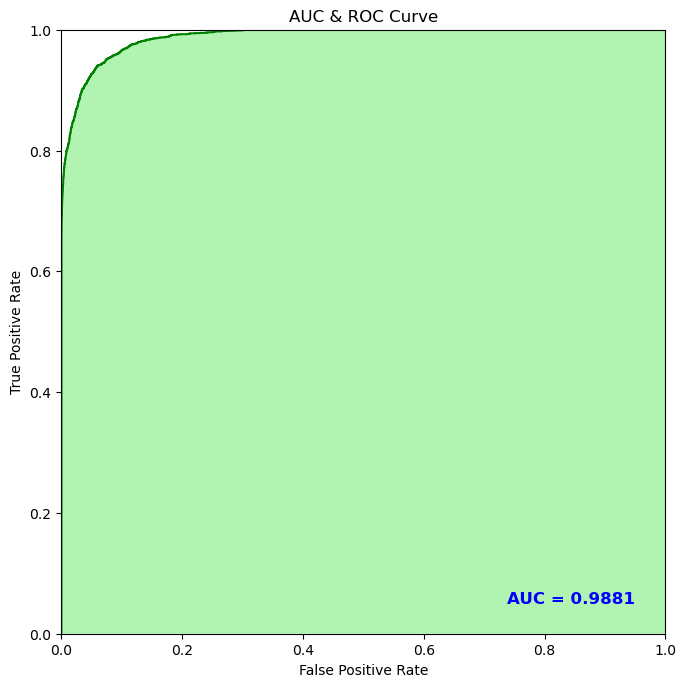

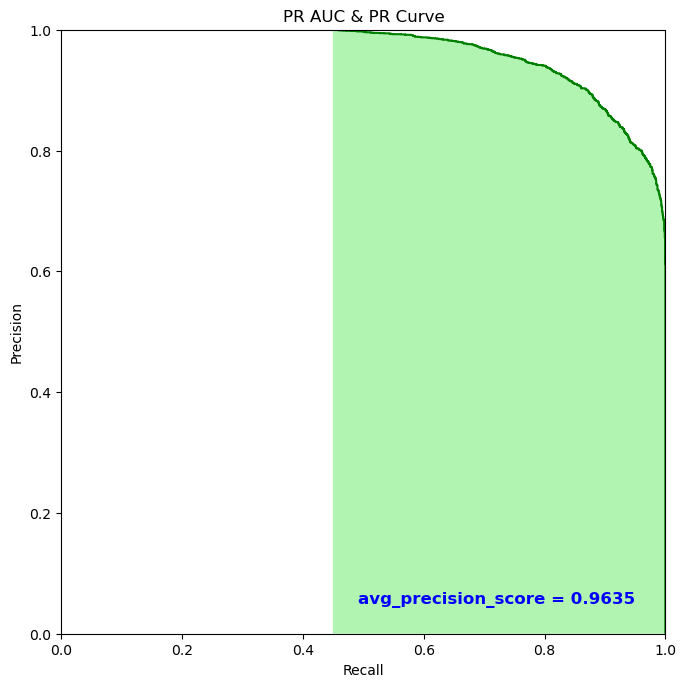

In [32]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

bas = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy Score: ", bas)

s = model.score(X_test, y_test)
print("Score: ", s)

bscore = brier_score_loss(y_test, y_prob)
print("Brier score: ", bscore)

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews corrcoef: ", mcc)

print("Classification report:\n", classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_prob)

prauc = average_precision_score(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, y_prob)

if len(true_positive_rate) < len(recall):
    tpr = np.append(true_positive_rate, (len(recall)-len(true_positive_rate)) * [None])
    fpr = np.append(false_positive_rate, (len(recall)-len(false_positive_rate)) * [None])
    tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : tpr, 'FPR': fpr,
    'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'delta': '182'})
    tmp = tmp.astype({'TPR': np.float64, 'FPR': np.float64})
else:
    tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : true_positive_rate, 'FPR': false_positive_rate,
    'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'delta': '182'})
# tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : true_positive_rate, 'FPR': false_positive_rate,
#     'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'method': 'GBDT'})
tmp.to_csv('assets/auc_res_250.tsv', index = False, sep='\t', mode = 'a', header = None, float_format='%.18f')

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("PR AUC & PR Curve")
plt.plot(precision, recall, 'g')
plt.fill_between(precision, recall, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'avg_precision_score = %0.4f' % prauc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [33]:
print(df[df['Dropout'] == True]['Dropout'].count())

14222


### Delta a 2 mesi

In [34]:
sentinels = ['None', 'n.d.', ' ', '']
df = pd.read_csv('assets/yid_out_2m.tsv', sep='\t', na_values=sentinels)

In [35]:
df.valoreIntero.fillna(df.valoreIntero.mean(), inplace=True)
df.mediaVoto.fillna(df.mediaVoto.mean(), inplace=True)
df.votoDiploma.fillna(round(df.votoDiploma.mean()), inplace=True)

df = df.drop(['luogoDiNascita', 'nazioneNascita'], axis=1)
df = df.astype({'valoreIntero': np.int64, 'votoDiploma': np.int32})
# print(pd.isnull(df).sum() > 0)
print(df.shape)

(70018, 24)


In [37]:
y = df.Dropout
X = df.drop(['ID_Stud', 'Dropout', 'lastLogin', 'annoAccaCors', 'ultIscr'], axis = 1)
# print(X.head())

val = {True: 1, False: 0}
X["sesso"] = X["sesso"].map(val)
X = X.astype({'sesso': np.int32})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print("Training Set shape: {}".format(X_train.shape))
print("Test Set shape: {}".format(X_test.shape))

Training Set shape: (56014, 19)
Test Set shape: (14004, 19)


In [38]:
ohe_elements =  ['cittadinanza', 'facolta', 'tipoIscrizione']
with open('assets/encoder.pickle', 'rb') as f:
    encoder = pickle.load(f)
feature_arr = encoder.transform(X_train[ohe_elements]).toarray()
feature_labels = encoder.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
X_train = X_train.reset_index(drop=True)
X_train = X_train.join(encoded_df)
X_train = X_train.drop(ohe_elements, axis=1)
X_train.head()

,annoCorso,eta,codCorso,creditiTotali,flagIdentificato,primaIscr,sesso,tipoCorso,tipoStudente,valoreIntero,...,facolta_LETTERE E FILOSOFIA,facolta_MEDICINA E ODONTOIATRIA,facolta_MEDICINA E PSICOLOGIA,"facolta_SCIENZE MATEMATICHE, FISICHE E NATURALI","facolta_SCIENZE POLITICHE, SOCIOLOGIA, COMUNICAZIONE",facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE,tipoIscrizione_FUORI CORSO,tipoIscrizione_IMMATRICOLAZIONE,tipoIscrizione_IN CORSO,tipoIscrizione_RIPETENTE
0,1,23,30046,180,1,4,1,27,2,39056,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,26,16004,180,1,6,1,27,2,28534,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,23,30043,180,1,4,0,27,2,23401,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,24,15936,180,0,4,1,27,2,70737,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3,24,29969,180,1,4,0,27,2,20816,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [39]:
feature_arr = encoder.transform(X_test[ohe_elements]).toarray()
feature_labels = encoder.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
X_test = X_test.reset_index(drop=True)
X_test = X_test.join(encoded_df)
X_test = X_test.drop(ohe_elements, axis=1)

X_test.head()

,annoCorso,eta,codCorso,creditiTotali,flagIdentificato,primaIscr,sesso,tipoCorso,tipoStudente,valoreIntero,...,facolta_LETTERE E FILOSOFIA,facolta_MEDICINA E ODONTOIATRIA,facolta_MEDICINA E PSICOLOGIA,"facolta_SCIENZE MATEMATICHE, FISICHE E NATURALI","facolta_SCIENZE POLITICHE, SOCIOLOGIA, COMUNICAZIONE",facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE,tipoIscrizione_FUORI CORSO,tipoIscrizione_IMMATRICOLAZIONE,tipoIscrizione_IN CORSO,tipoIscrizione_RIPETENTE
0,3,23,29864,180,1,3,1,27,2,60907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,26,29391,120,1,4,0,28,2,32313,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,25,30055,120,1,3,0,28,2,30814,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,27,26694,300,1,4,0,23,2,33302,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,24,16074,180,0,5,1,27,2,32313,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
if "facolta_PSICOLOGIA 1" in X_train.columns:
    X_train = X_train.drop(['facolta_PSICOLOGIA 1'], axis=1)
    X_test = X_test.drop(['facolta_PSICOLOGIA 1'], axis=1)

In [40]:
model = GradientBoostingClassifier(n_estimators=500, min_samples_leaf=16, max_depth=8, loss='exponential', learning_rate=0.01)
model = model.fit(X_train, y_train)

Confusion matrix:
 [[10987   173]
 [  477  2367]]
Balanced Accuracy Score:  0.9083883444489814
Score:  0.9535846900885462
Brier score:  0.03256154048442478
Matthews corrcoef:  0.8527373403945613
Classification report:
               precision    recall  f1-score   support

       False       0.96      0.98      0.97     11160
        True       0.93      0.83      0.88      2844

    accuracy                           0.95     14004
   macro avg       0.95      0.91      0.93     14004
weighted avg       0.95      0.95      0.95     14004



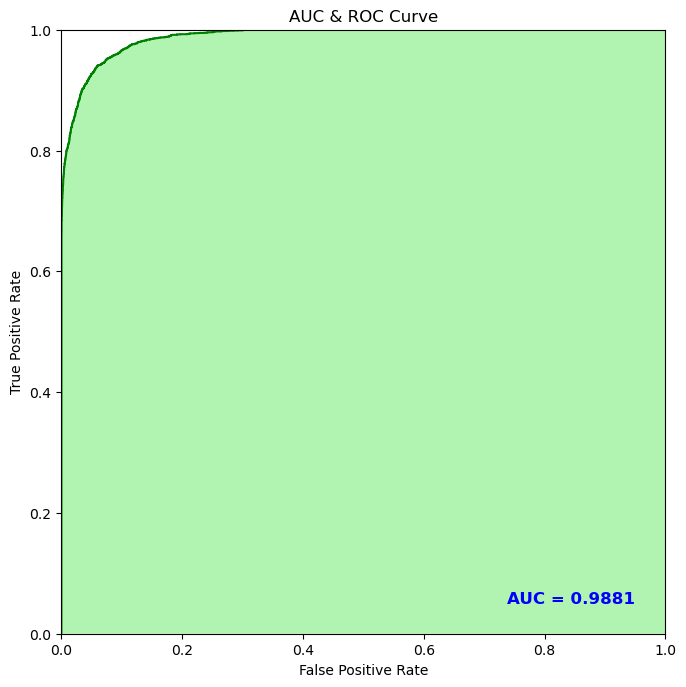

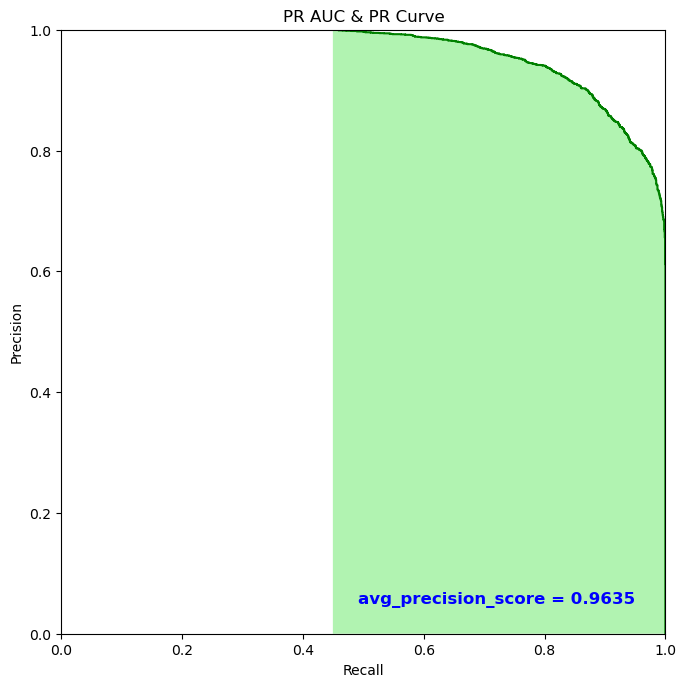

In [41]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

bas = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy Score: ", bas)

s = model.score(X_test, y_test)
print("Score: ", s)

bscore = brier_score_loss(y_test, y_prob)
print("Brier score: ", bscore)

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews corrcoef: ", mcc)

print("Classification report:\n", classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_prob)

prauc = average_precision_score(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, y_prob)

if len(true_positive_rate) < len(recall):
    tpr = np.append(true_positive_rate, (len(recall)-len(true_positive_rate)) * [None])
    fpr = np.append(false_positive_rate, (len(recall)-len(false_positive_rate)) * [None])
    tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : tpr, 'FPR': fpr,
    'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'delta': '128'})
    tmp = tmp.astype({'TPR': np.float64, 'FPR': np.float64})
else:
    tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : true_positive_rate, 'FPR': false_positive_rate,
    'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'delta': '128'})
# tmp = pd.DataFrame.from_dict({'BAS': bas, 'simplyScore': s, 'brier': bscore, 'matthews': mcc, 'TPR' : true_positive_rate, 'FPR': false_positive_rate,
#     'valAUC': auc, 'precision': precision, 'recall': recall, 'valPRAUC': prauc, 'method': 'GBDT'})
tmp.to_csv('assets/auc_res_250.tsv', index = False, sep='\t', mode = 'a', header = None, float_format='%.18f')

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("PR AUC & PR Curve")
plt.plot(precision, recall, 'g')
plt.fill_between(precision, recall, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'avg_precision_score = %0.4f' % prauc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [42]:
print(df[df['Dropout'] == True]['Dropout'].count())

14222
